In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import os
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
from sklearn.model_selection import train_test_split
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
# Arrangement of data directories and filepaths

data_dir = "/content/"
TimeAge_filepath = os.path.join(data_dir, "TimeAge.csv")
TimeGender_filepath = os.path.join(data_dir, "TimeGender.csv")
Policy_filepath = os.path.join(data_dir, "Policy.csv")
Time_filepath = os.path.join(data_dir, "Time.csv")
TimeProvince_filepath = os.path.join(data_dir, "TimeProvince.csv")
PatientInfo_filepath = os.path.join(data_dir, "PatientInfo.csv")
SearchTrend_filepath = os.path.join(data_dir, "SearchTrend.csv")
SeoulFloating_filepath = os.path.join(data_dir, "SeoulFloating.csv")
Weather_filepath = os.path.join(data_dir, "Weather.csv")
Case_filepath = os.path.join(data_dir, "Case.csv")
Region_filepath = os.path.join(data_dir, "Region.csv")

In [ ]:
# Arrangement of dataframes

TimeAge_df = pd.read_csv(TimeAge_filepath)
TimeGender_df = pd.read_csv(TimeGender_filepath)
Policy_df = pd.read_csv(Policy_filepath)
Time_df = pd.read_csv(Time_filepath)
TimeProvince_df = pd.read_csv(TimeProvince_filepath)
PatientInfo_df = pd.read_csv(PatientInfo_filepath)
SearchTrend_df = pd.read_csv(SearchTrend_filepath)
SeoulFloating_df = pd.read_csv(SeoulFloating_filepath)
Weather_df = pd.read_csv(Weather_filepath)
Case_df = pd.read_csv(Case_filepath)
Region_df = pd.read_csv(Region_filepath)

In [ ]:
# The dataframes that include a `date` column in them
dfs = [TimeAge_df, TimeGender_df, TimeProvince_df, Time_df, SearchTrend_df, SeoulFloating_df, Weather_df]

In [ ]:
# Dataframes with dates (2020-03-02 - 2020-06-30)
TimeAge_df = pd.pivot(TimeAge_df, index='date', columns="age", values=['confirmed', 'deceased']).swaplevel(0,1,axis=1).reset_index()
TimeAge_df.columns = TimeAge_df.columns.map('_'.join)

TimeGender_df = pd.pivot(TimeGender_df, index='date', columns="sex", values=['confirmed', 'deceased']).swaplevel(0,1,axis=1).reset_index()
TimeGender_df.columns = TimeGender_df.columns.map('_'.join)

TimeAgeGender_df = pd.merge(TimeAge_df, TimeGender_df, on='date_')

# Dataframes with dates (2020-01-20 - 2020-06-30)
TimeProvince_df = pd.pivot(TimeProvince_df, index='date', columns="province", values=['confirmed', 'deceased', 'released']).swaplevel(0,1,axis=1).reset_index()
TimeProvince_df.columns = TimeProvince_df.columns.map('_'.join)

#Time_df
Time_df['index'] = range(0, len(Time_df))

TimeProvinceTime_df = pd.merge(TimeProvince_df, Time_df, how='left', left_on=['date_'], right_on=['date'])
TimeProvinceTime_df = TimeProvinceTime_df.drop('date', 1)

# Dataframes with dates (2020-01-01 - 2020-06-29)

Weather_df = pd.pivot(Weather_df, index='date', columns="province", values=['code','avg_temp', 'min_temp', 'max_temp', 'precipitation', 'max_wind_speed', 'most_wind_direction', 'avg_relative_humidity']).swaplevel(0,1,axis=1).reset_index()
Weather_df.columns = Weather_df.columns.map('_'.join)

#SearchTrend_df

WeatherSearchTrend_df = pd.merge(Weather_df, SearchTrend_df, how='left', left_on=['date_'], right_on=['date'])
WeatherSearchTrend_df = WeatherSearchTrend_df.drop('date', 1)

# Dataframes with dates (2020-01-01 - 2020-05-31)
#SeoulFloating_df



In [ ]:
final_df = Time_df.merge(TimeAge_df, how='inner', left_on='date', right_on='date_').drop(['date_', 'index'], axis = 1)
final_df = final_df.merge(TimeGender_df, how='inner', left_on='date', right_on='date_').drop(['date_'], axis = 1)
final_df = final_df.merge(TimeProvince_df, how='inner', left_on='date', right_on='date_').drop(['date_'], axis = 1)
final_df = final_df.merge(Weather_df, how='inner', left_on='date', right_on='date_').drop(['date_'], axis = 1)
final_df = final_df.merge(SearchTrend_df, how='inner', left_on='date', right_on='date')
#final_df = final_df.merge(SeoulFloating_df, how='inner', left_on='date', right_on='date')

final_df=final_df.dropna(axis='columns')

In [ ]:
final_df

date  time     test  negative  confirmed  released  deceased  \
0    2020-03-02     0   109591     71580       4212        31        22   
1    2020-03-03     0   125851     85484       4812        34        28   
2    2020-03-04     0   136707    102965       5328        41        32   
3    2020-03-05     0   146541    118965       5766        88        35   
4    2020-03-06     0   164740    136624       6284       108        42   
..          ...   ...      ...       ...        ...       ...       ...   
115  2020-06-25     0  1220478   1189015      12563     10974       282   
116  2020-06-26     0  1232315   1200885      12602     11172       282   
117  2020-06-27     0  1243780   1211261      12653     11317       282   
118  2020-06-28     0  1251695   1219975      12715     11364       282   
119  2020-06-29     0  1259954   1228698      12757     11429       282   

     0s_confirmed  10s_confirmed  20s_confirmed  ...  \
0              32            169           1235  ...   
1              34            204           1417  ...   
2              34            233           1575  ...   
3              38            257           1727  ...   
4              45            292           1877  ...   
..            ...            ...            ...  ...   
115           183            696           3309  ...   
116           184            698           3317  ...   
117           185            700           3331  ...   
118           187            703           3343  ...   
119           190            704           3352  ...   

     Incheon_avg_relative_humidity  Jeju-do_avg_relative_humidity  \
0                          58.8000                        61.9000   
1                          63.5000                        70.3000   
2                          60.9000                        58.6000   
3                          55.6000                        55.3000   
4                          53.5000                        65.3000   
..                             ...                            ...   
115                        97.1000                        93.3000   
116                        89.0000                        82.0000   
117                        76.8000                        89.9000   
118                        85.0000                        80.4000   
119                        84.5000                        87.4000   

     Jeollabuk-do_avg_relative_humidity  Jeollanam-do_avg_relative_humidity  \
0                               60.1000                             47.9000   
1                               65.4000                             67.3000   
2                               63.3000                             51.5000   
3                               56.3000                             42.0000   
4                               49.1000                             58.0000   
..                                  ...                                 ...   
115                             83.4000                             99.4000   
116                             77.3000                             80.1000   
117                             72.6000                             87.4000   
118                             77.6000                             79.1000   
119                             85.1000                             97.9000   

     Seoul_avg_relative_humidity  Ulsan_avg_relative_humidity   cold    flu  \
0                        55.3000                      57.6000 0.8816 0.1335   
1                        57.0000                      74.6000 0.6793 0.1192   
2                        53.4000                      47.8000 0.8258 0.1079   
3                        47.5000                      47.3000 0.6492 0.0974   
4                        46.8000                      48.5000 0.5863 0.0916   
..                           ...                          ...    ...    ...   
115                      91.0000                      96.5000 0.1207 0.0419   
116                      82

In [ ]:
X = final_df[final_df.columns[~final_df.columns.isin(['date','time','confirmed','negative'])]]
y = final_df['confirmed']
features = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.33, random_state=42)

In [ ]:
stat, p = stats.normaltest(y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=34.528, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 1.935853804476242
Skewness of normal distribution: -1.3593599649884702


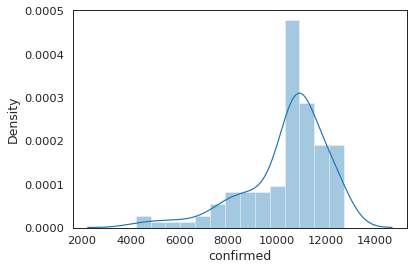

In [ ]:
# print(df.Global_active_power.describe())
sns.distplot(final_df['confirmed']);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(y)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(y)))

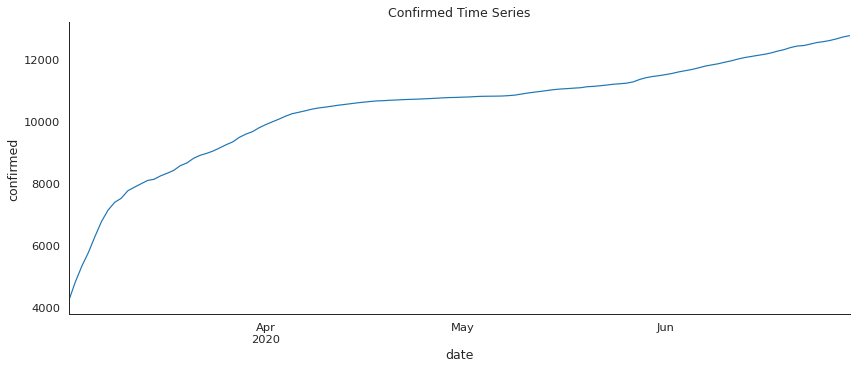

In [ ]:
df1=final_df.loc[:,['date','confirmed']]
df1.set_index('date',inplace=True)
df1.index = pd.to_datetime(df1.index)
df1.plot(figsize=(12,5))
plt.ylabel('confirmed')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Confirmed Time Series')
sns.despine(top=True)
plt.show();

count       mean       std       min       25%        50%  \
confirmed 120.0000 10402.9833 1705.2161 4212.0000 9861.7500 10769.5000   

                 75%        max  
confirmed 11447.7500 12757.0000

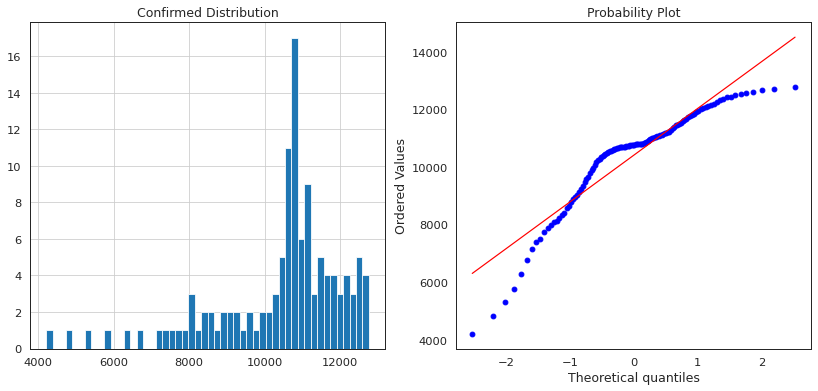

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
y.hist(bins=50)
plt.title('Confirmed Distribution')

plt.subplot(1,2,2)
stats.probplot(final_df['confirmed'], plot=plt);
df1.describe().T

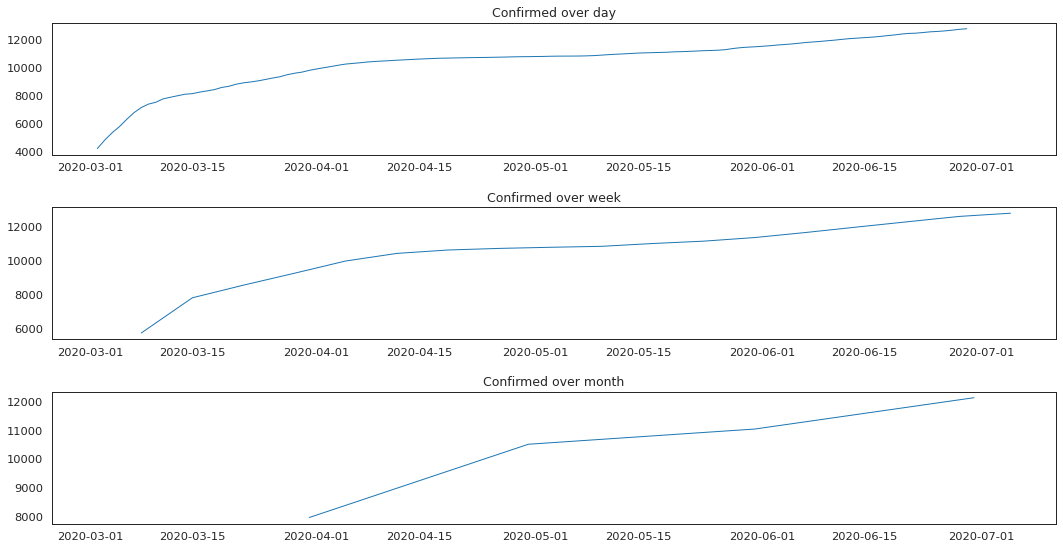

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['confirmed'].resample('D').mean(),linewidth=1)
ax1.set_title('Confirmed over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['confirmed'].resample('W').mean(),linewidth=1)
ax2.set_title('Confirmed over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['confirmed'].resample('M').mean(),linewidth=1)
ax3.set_title('Confirmed over month')
ax3.tick_params(axis='both', which='major')

In [ ]:
df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

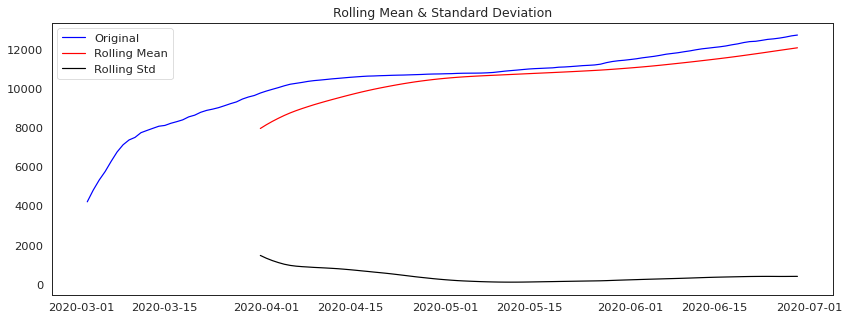

<Results of Dickey-Fuller Test>
Test Statistic                  0.1210
p-value                         0.9675
#Lags Used                     12.0000
Number of Observations Used   107.0000
Critical Value (1%)            -3.4930
Critical Value (5%)            -2.8890
Critical Value (10%)           -2.5814
dtype: float64


In [ ]:
test_stationarity(df2.confirmed.dropna())

In [ ]:
X = final_df[ final_df.columns[~ final_df.columns.isin(['test', 'date', 'negative', 'time'])]] #numpy.ndarray
y = final_df['confirmed'].values.reshape(-1,1)

In [ ]:
dataset = X.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 2/3)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=look_back, validation_data=(X_test, Y_test), 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=True)

# Training Phase
model.summary()

Epoch 1/100
15918/15918 [==============================] - 56s 3ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 2/100
15918/15918 [==============================] - 64s 4ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 3/100
15918/15918 [==============================] - 53s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 4/100
15918/15918 [==============================] - 50s 3ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 5/100
15918/15918 [==============================] - 51s 3ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/100
15918/15918 [==============================] - 53s 3ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 7/100
15918/15918 [==============================] - 52s 3ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 8/100
15918/15918 [==============================] - 51s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 9/100
15918/15918 [==============================] - 56s 4ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 10/100
15918/15918 [====================

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 277.66788349492424
Train Root Mean Squared Error: 308.7000950148428
Test Mean Absolute Error: 518.8318621471418
Test Root Mean Squared Error: 522.3886566308823


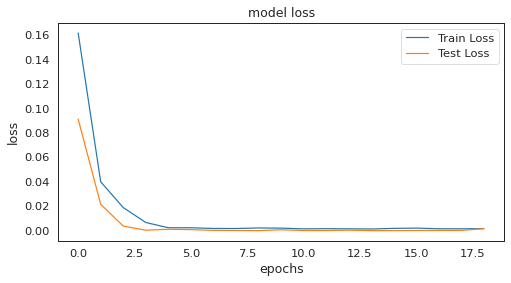

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

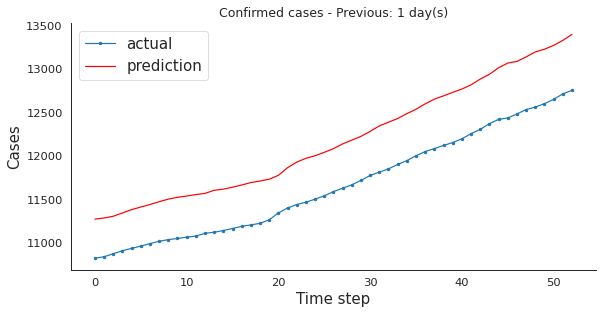

In [ ]:
lim = Y_test.shape[1]
aa=[x for x in range(lim)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:lim], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:lim], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Confirmed cases - Previous: {} day(s)'.format(look_back))
plt.ylabel('Cases', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
import shap

In [ ]:

e = shap.DeepExplainer((regressor.layers[0].input, regressor.layers[-1].output),data)
test1 = X_train[random_ind[500:1000]]
shap_val = e.shap_values(test1)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
f_names = [‘RSI_14D’,’STOK’,’STOD’,’ROC’,’Momentum’,’CCI’,’ADX’,’MACD’,’Money_Flow_Index’,’WillR’,’INRchange’]
x_pos = [i for i, _ in enumerate(f_names)]
plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title(“Yesterday’s features (time-step 2)”)
plt2 = plt.subplot(312,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title(“The day before yesterday’s features(time-step 1)”)
plt.tight_layout()
plt.show()

SyntaxError: ignored

In [ ]:
import shap

# load your data here, e.g. X and y
# create and fit your model here

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

#shap.summary_plot(shap_values, X, plot_type="bar")

shap.summary_plot(shap_values, X_train, plot_type="bar", matplotlib=True)
plt.show()

ValueError: ignored

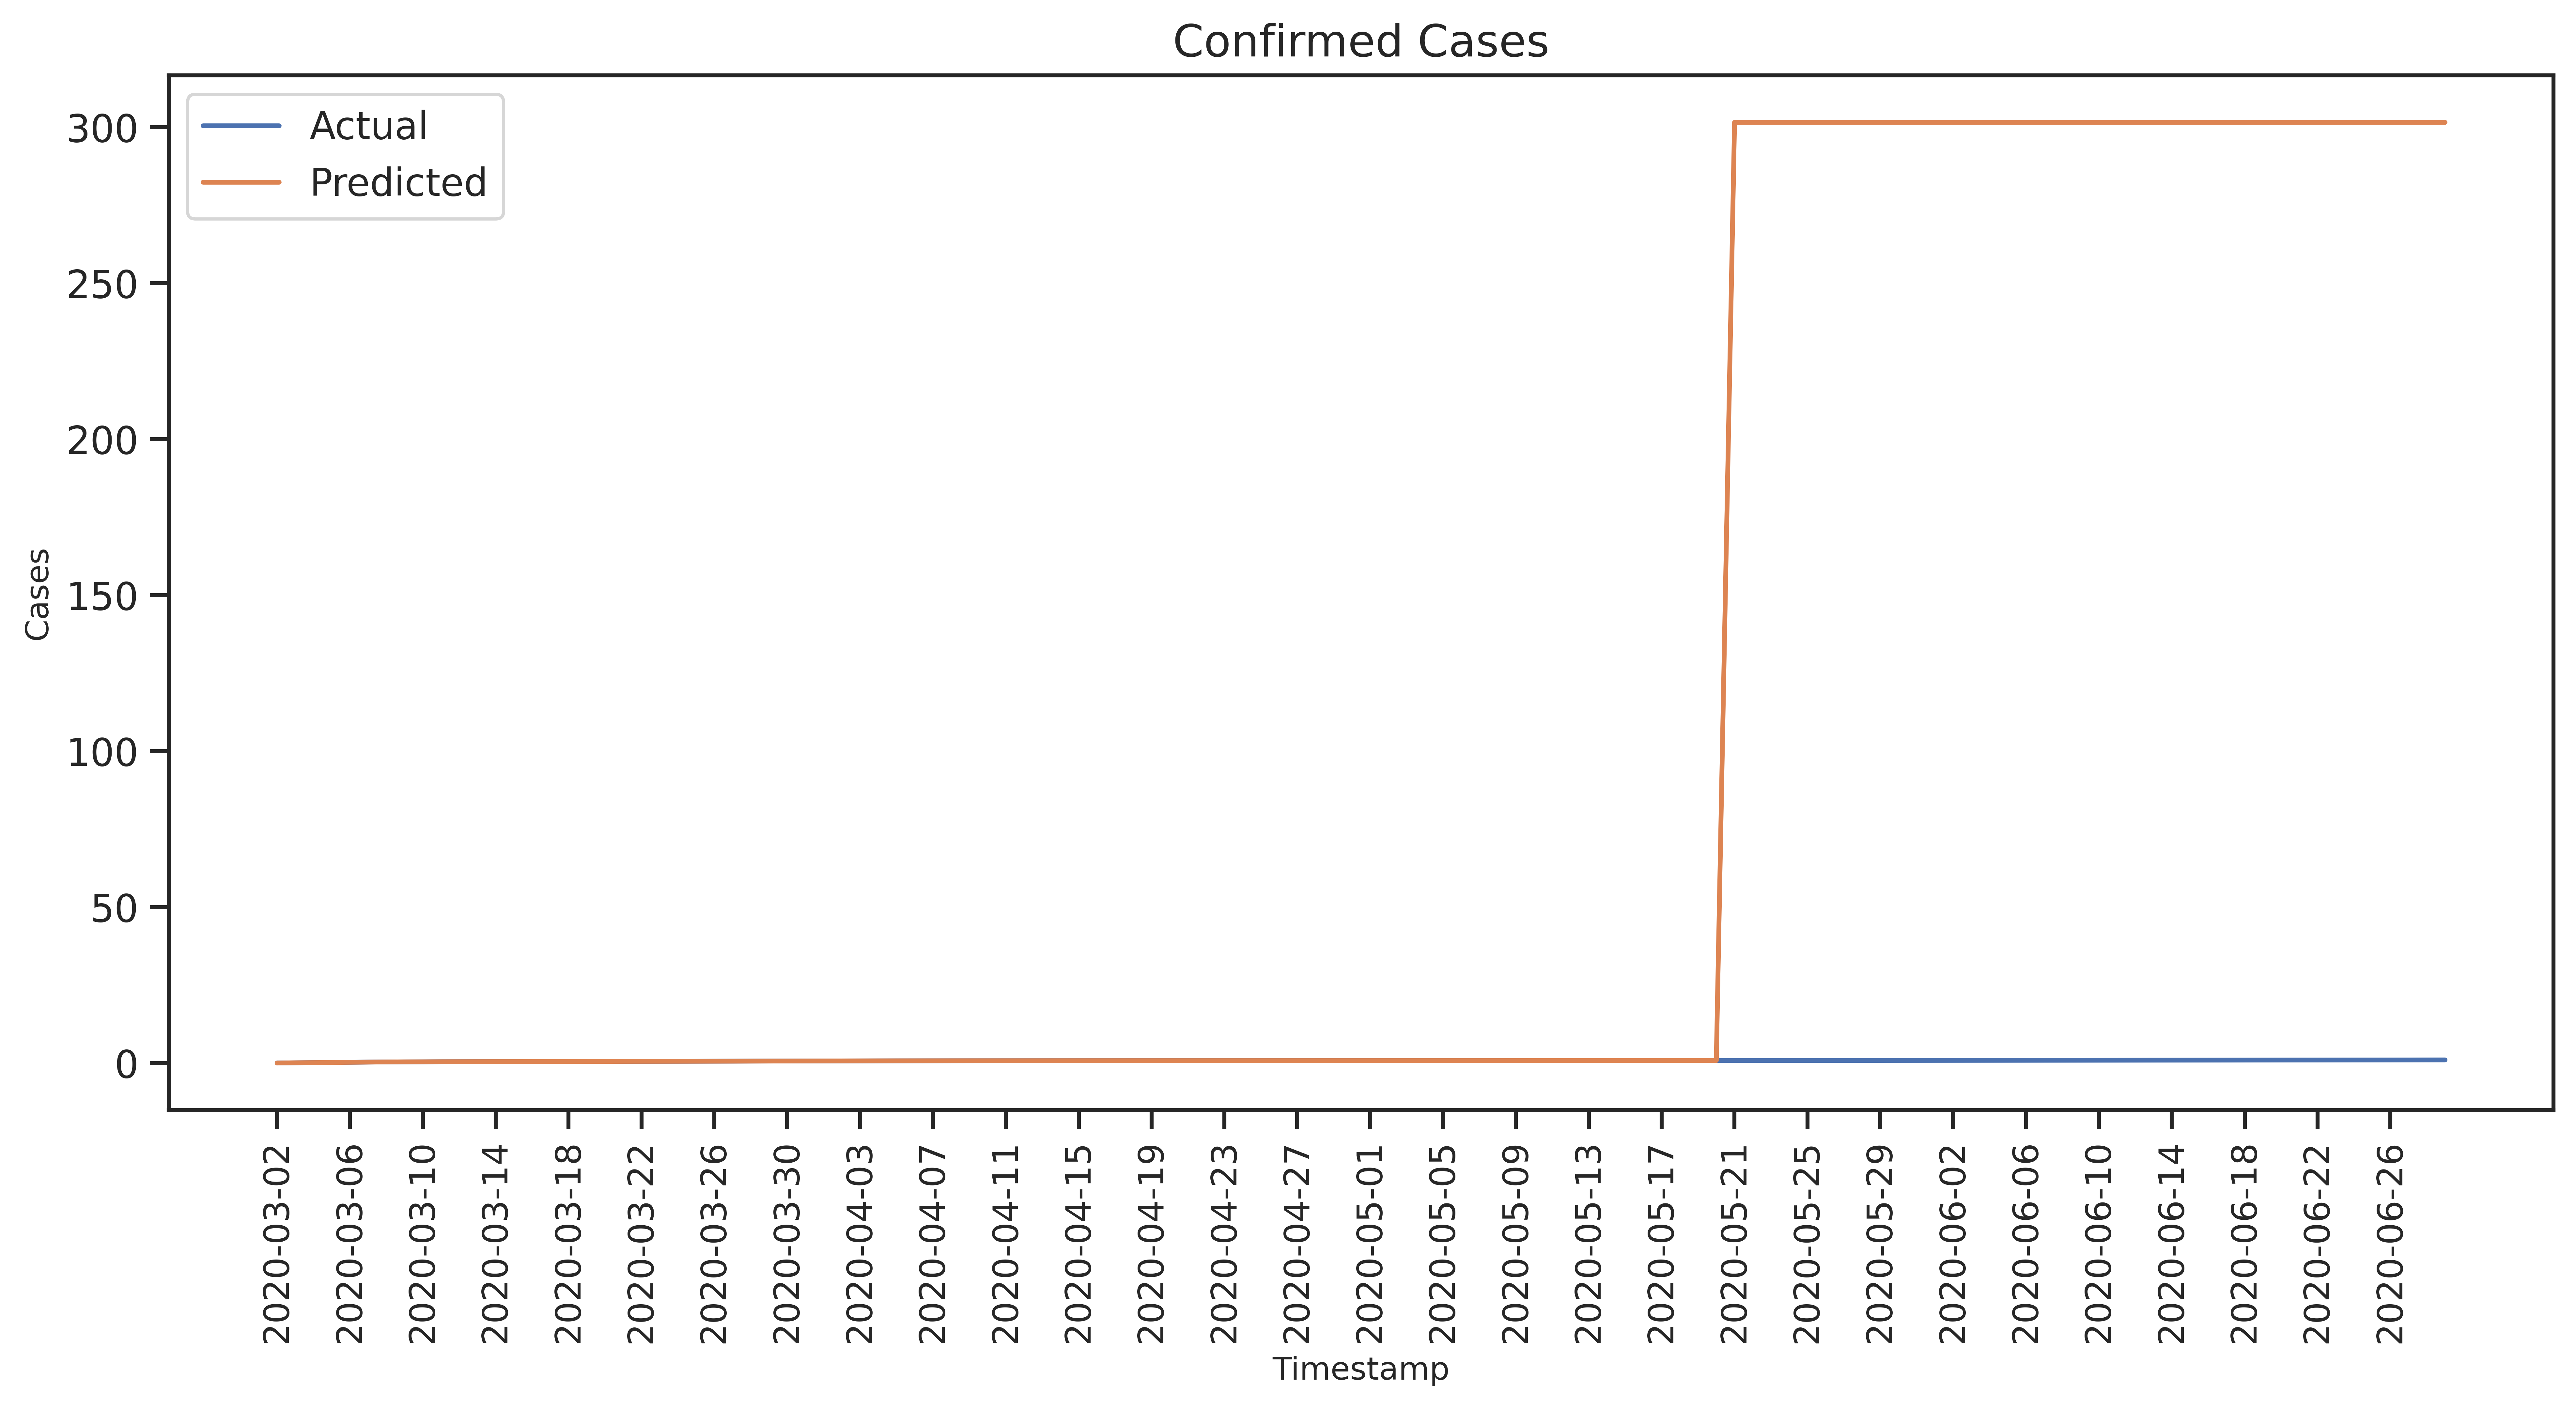

<Figure size 8400x4200 with 0 Axes>

In [ ]:
dates = final_df['date'].to_list()

sns.set(rc={"figure.dpi":700, 'savefig.dpi':700})
sns.set_style('ticks')
fontsize = 12

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Confirmed Cases", fontsize=14)
plt.ylabel("Cases", fontsize=10)
plt.xlabel("Timestamp", fontsize=10)

plt.xticks(list(range(len(dates))), dates[::4], rotation='vertical')
plt.locator_params(axis='x', nbins=len(dates)/4)
plt.yticks(fontsize= fontsize)

actual = list(y_train) + list(y_test)
predicted = list(y_train) + list(y_pred)

plt.plot(actual, label = 'Actual', linestyle='-')
plt.plot(predicted, label = 'Predicted', linestyle='-')


plt.legend(prop={'size': fontsize})
plt.show()
plt.clf()

In [ ]:
dates = TimeAge_df['date_'].unique()
ages_confirmed = list()
ages_deceased = list()
for col in TimeAge_df.columns.to_list():
  if 'confirmed' in col:
    ages_confirmed.append(col)
  if 'deceased' in col:
    ages_deceased.append(col)

TimeAge_dates_ages_confirmed = list()
TimeAge_dates_ages_deceased = list()
for date in dates:
  date_TimeAge_df = TimeAge_df[TimeAge_df['date_'] == date]
  TimeAge_ages_confirmed = dict()
  TimeAge_ages_deceased = dict()
  for age in ages_confirmed:
    date_age_TimeAge_df = date_TimeAge_df[age]
    TimeAge_ages_confirmed[age] = date_age_TimeAge_df.to_list()[0]
  for age in ages_deceased:
    date_age_TimeAge_df = date_TimeAge_df[age]
    TimeAge_ages_deceased[age] = date_age_TimeAge_df.to_list()[0]
  TimeAge_dates_ages_confirmed.append((date, TimeAge_ages_confirmed))
  TimeAge_dates_ages_deceased.append((date, TimeAge_ages_deceased))

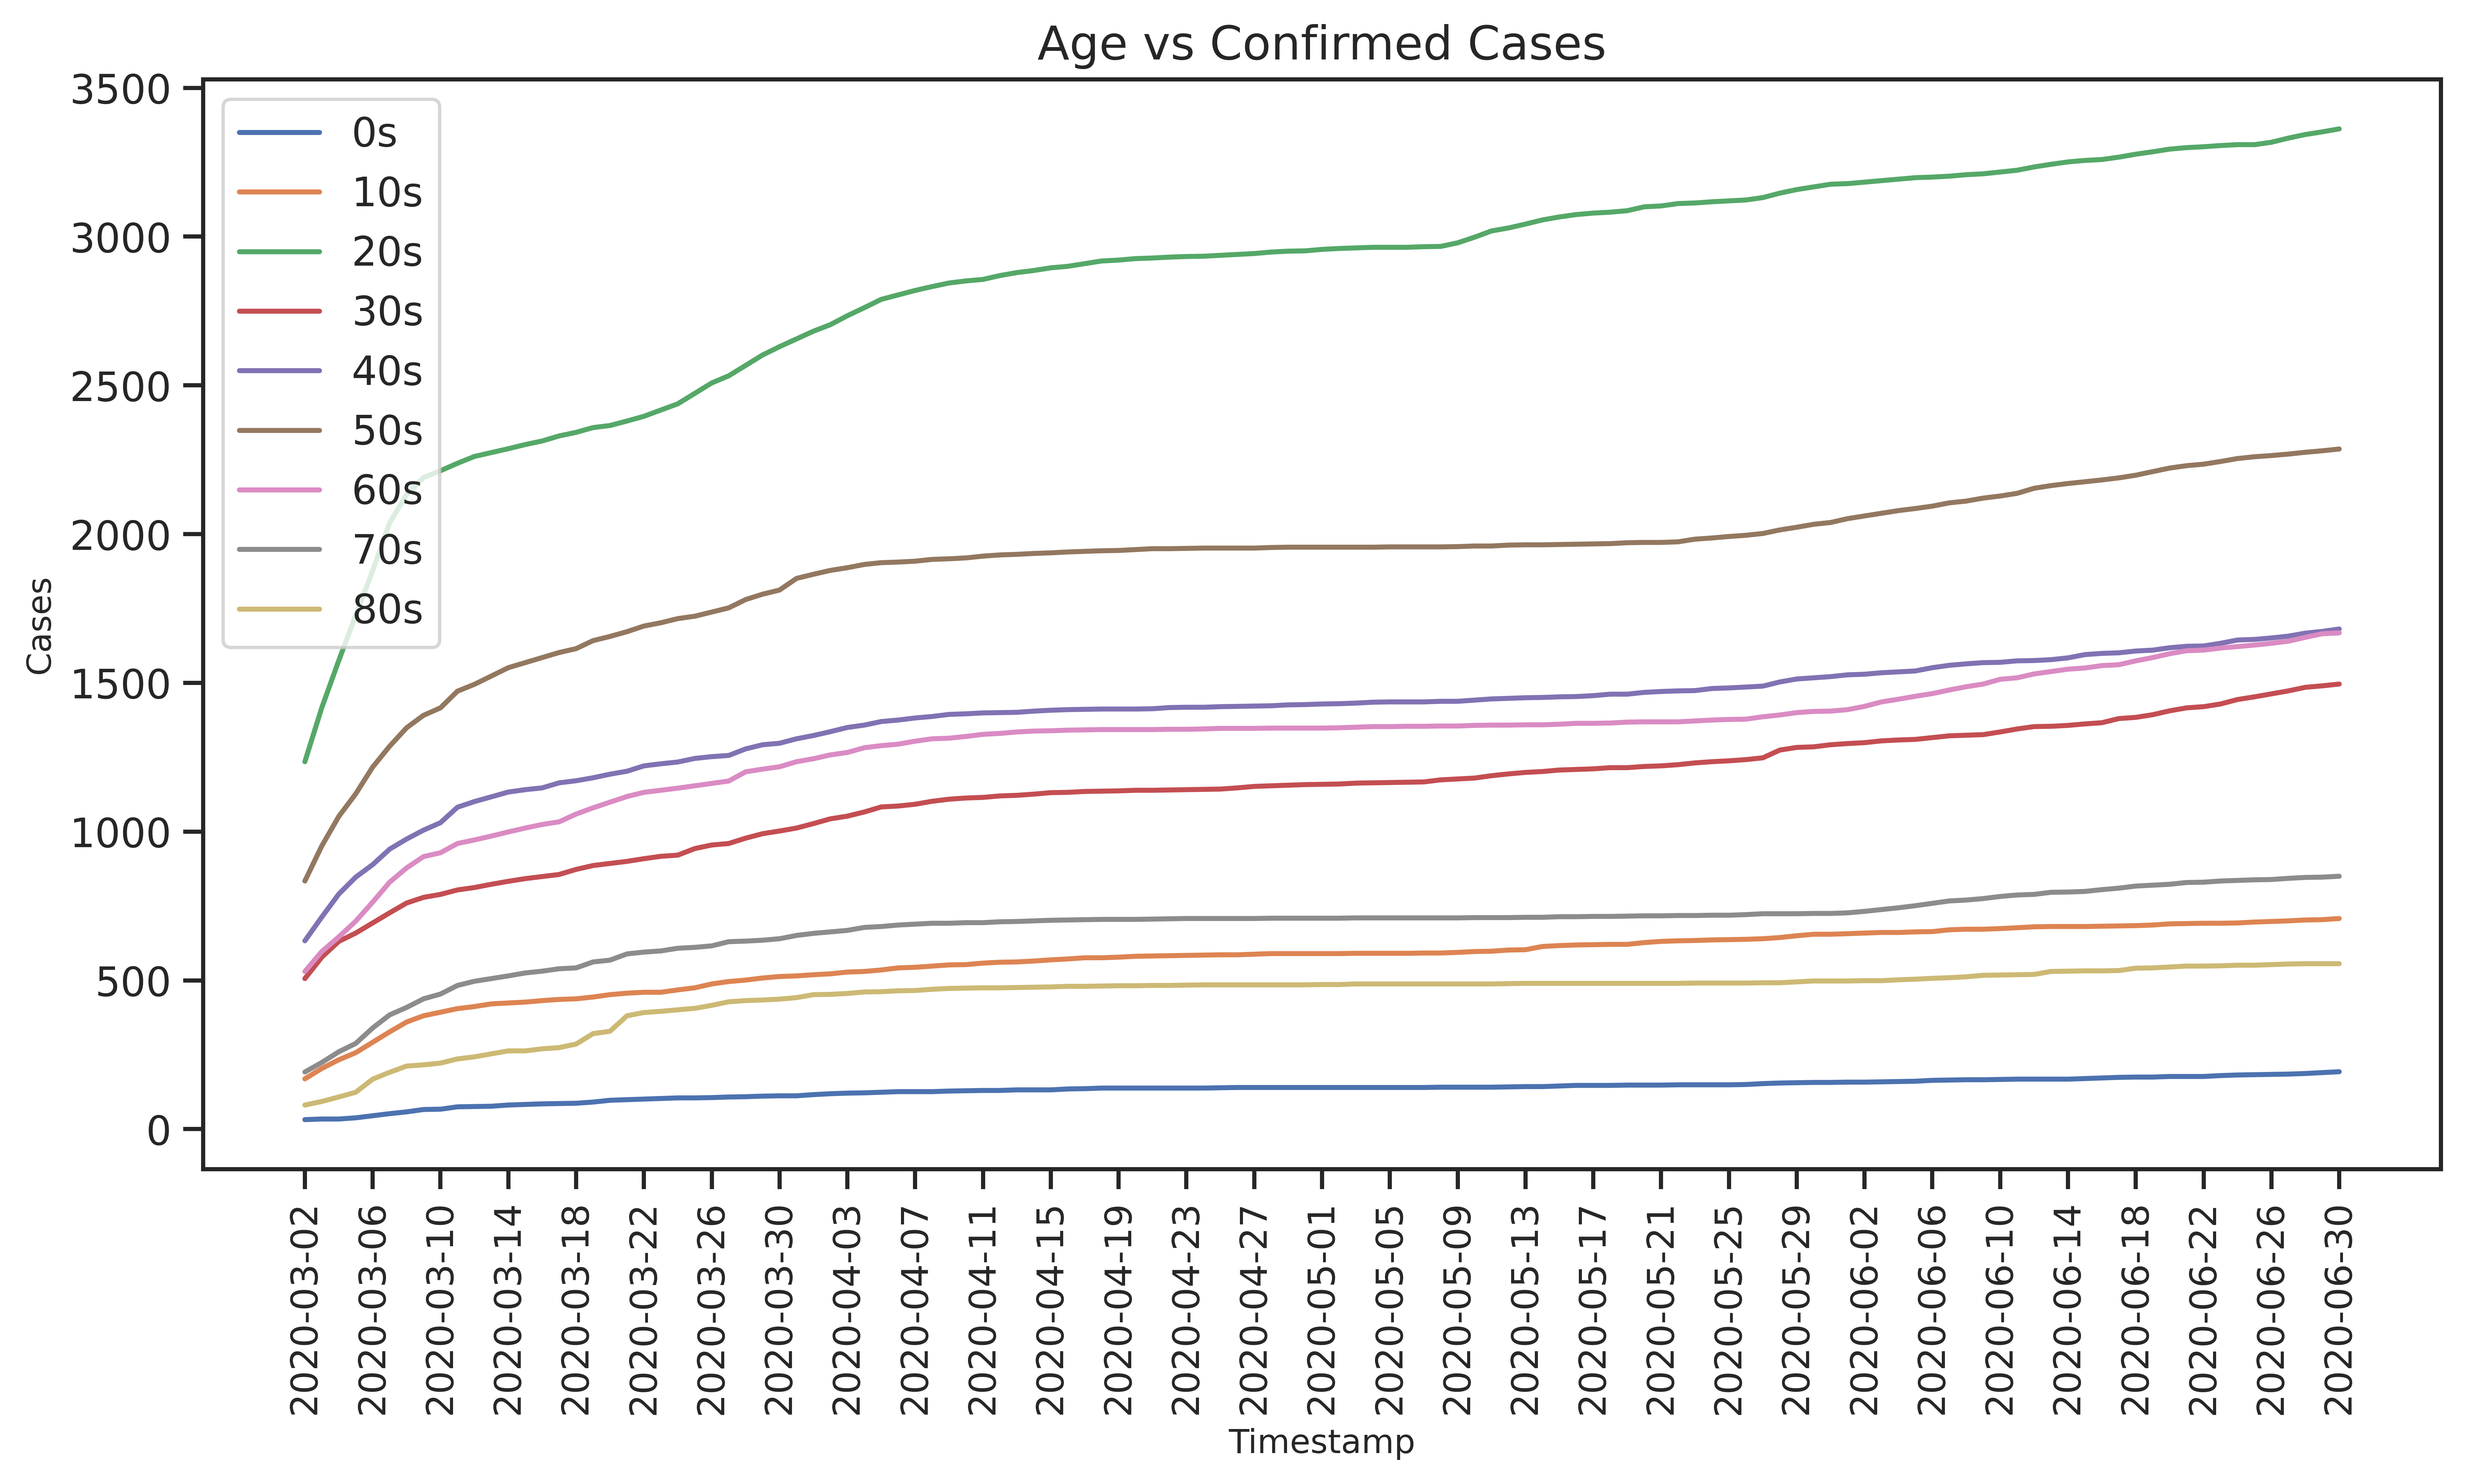

<Figure size 8400x4200 with 0 Axes>

In [ ]:
sns.set(rc={"figure.dpi":700, 'savefig.dpi':700})
sns.set_style('ticks')
fontsize = 12

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Age vs Confirmed Cases", fontsize=14)
plt.ylabel("Cases", fontsize=10)
plt.xlabel("Timestamp", fontsize=10)

plt.xticks(list(range(len(dates))), dates[::4], rotation='vertical')
plt.locator_params(axis='x', nbins=len(dates)/4)
plt.yticks(fontsize= fontsize)

for i in range(len(ages_confirmed)):
  age = [list(x[1].items())[i][0] for x in TimeAge_dates_ages_confirmed][0]
  age_list = [list(x[1].items())[i][1] for x in TimeAge_dates_ages_confirmed]
  plt.plot(age_list, label = str(age).split('_')[0], linestyle='-')


plt.legend(prop={'size': fontsize})
plt.show()
plt.clf()

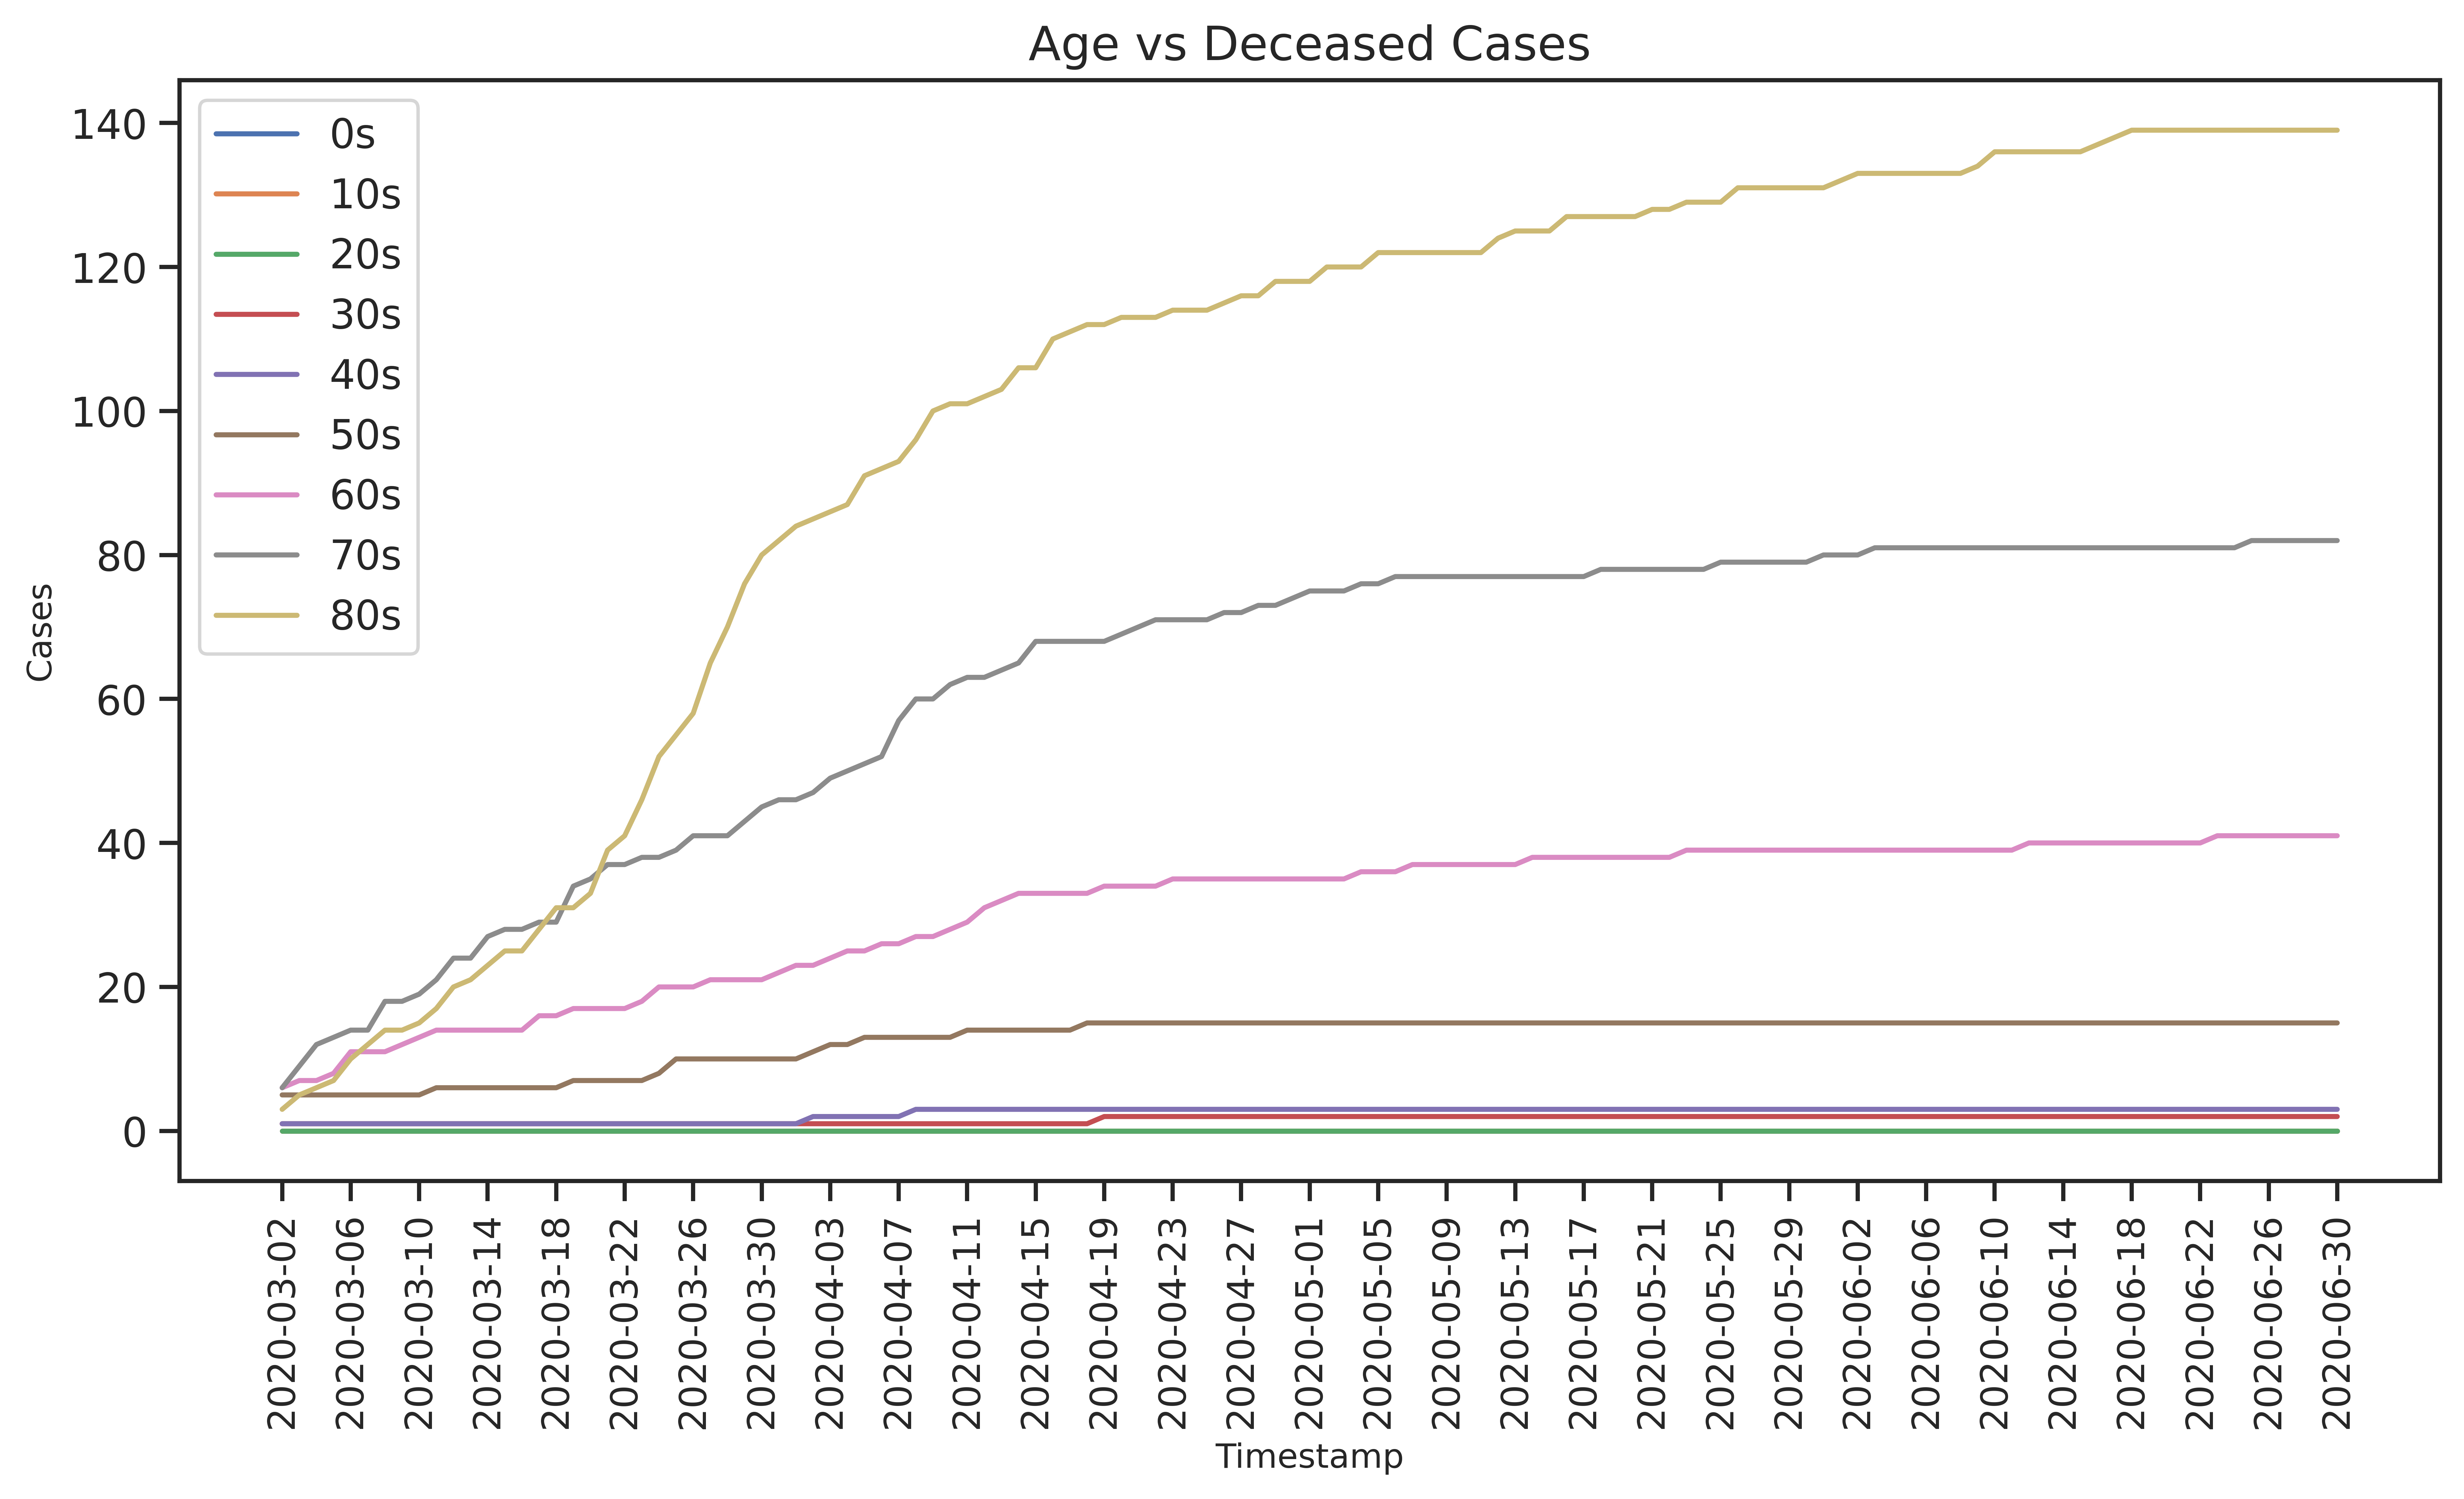

<Figure size 8400x4200 with 0 Axes>

In [ ]:
sns.set(rc={"figure.dpi":700, 'savefig.dpi':700})
sns.set_style('ticks')
fontsize = 12

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Age vs Deceased Cases", fontsize=14)
plt.ylabel("Cases", fontsize=10)
plt.xlabel("Timestamp", fontsize=10)

plt.xticks(list(range(len(dates))), dates[::4], rotation='vertical')
plt.locator_params(axis='x', nbins=len(dates)/4)
plt.yticks(fontsize= fontsize)

for i in range(len(ages_deceased)):
  age = [list(x[1].items())[i][0] for x in TimeAge_dates_ages_deceased][0]
  age_list = [list(x[1].items())[i][1] for x in TimeAge_dates_ages_deceased]
  plt.plot(age_list, label = str(age).split('_')[0], linestyle='-')


plt.legend(prop={'size': fontsize})
plt.show()
plt.clf()

In [ ]:
dates = TimeGender_df['date_'].unique()
sexes_confirmed = list()
sexes_deceased = list()
for col in TimeGender_df.columns.to_list():
  if 'confirmed' in col:
    sexes_confirmed.append(col)
  if 'deceased' in col:
    sexes_deceased.append(col)

TimeGender_dates_sexes_confirmed = list()
TimeGender_dates_sexes_deceased = list()
for date in dates:
  date_TimeGender_df = TimeGender_df[TimeGender_df['date_'] == date]
  TimeGender_sexes_confirmed = dict()
  TimeGender_sexes_deceased = dict()
  for sex in sexes_confirmed:
    date_sex_TimeGender_df = date_TimeGender_df[sex]
    TimeGender_sexes_confirmed[sex] = date_sex_TimeGender_df.to_list()[0]
  for sex in sexes_deceased:
    date_sex_TimeGender_df = date_TimeGender_df[sex]
    TimeGender_sexes_deceased[sex] = date_sex_TimeGender_df.to_list()[0]
  TimeGender_dates_sexes_confirmed.append((date, TimeGender_sexes_confirmed))
  TimeGender_dates_sexes_deceased.append((date, TimeGender_sexes_deceased))

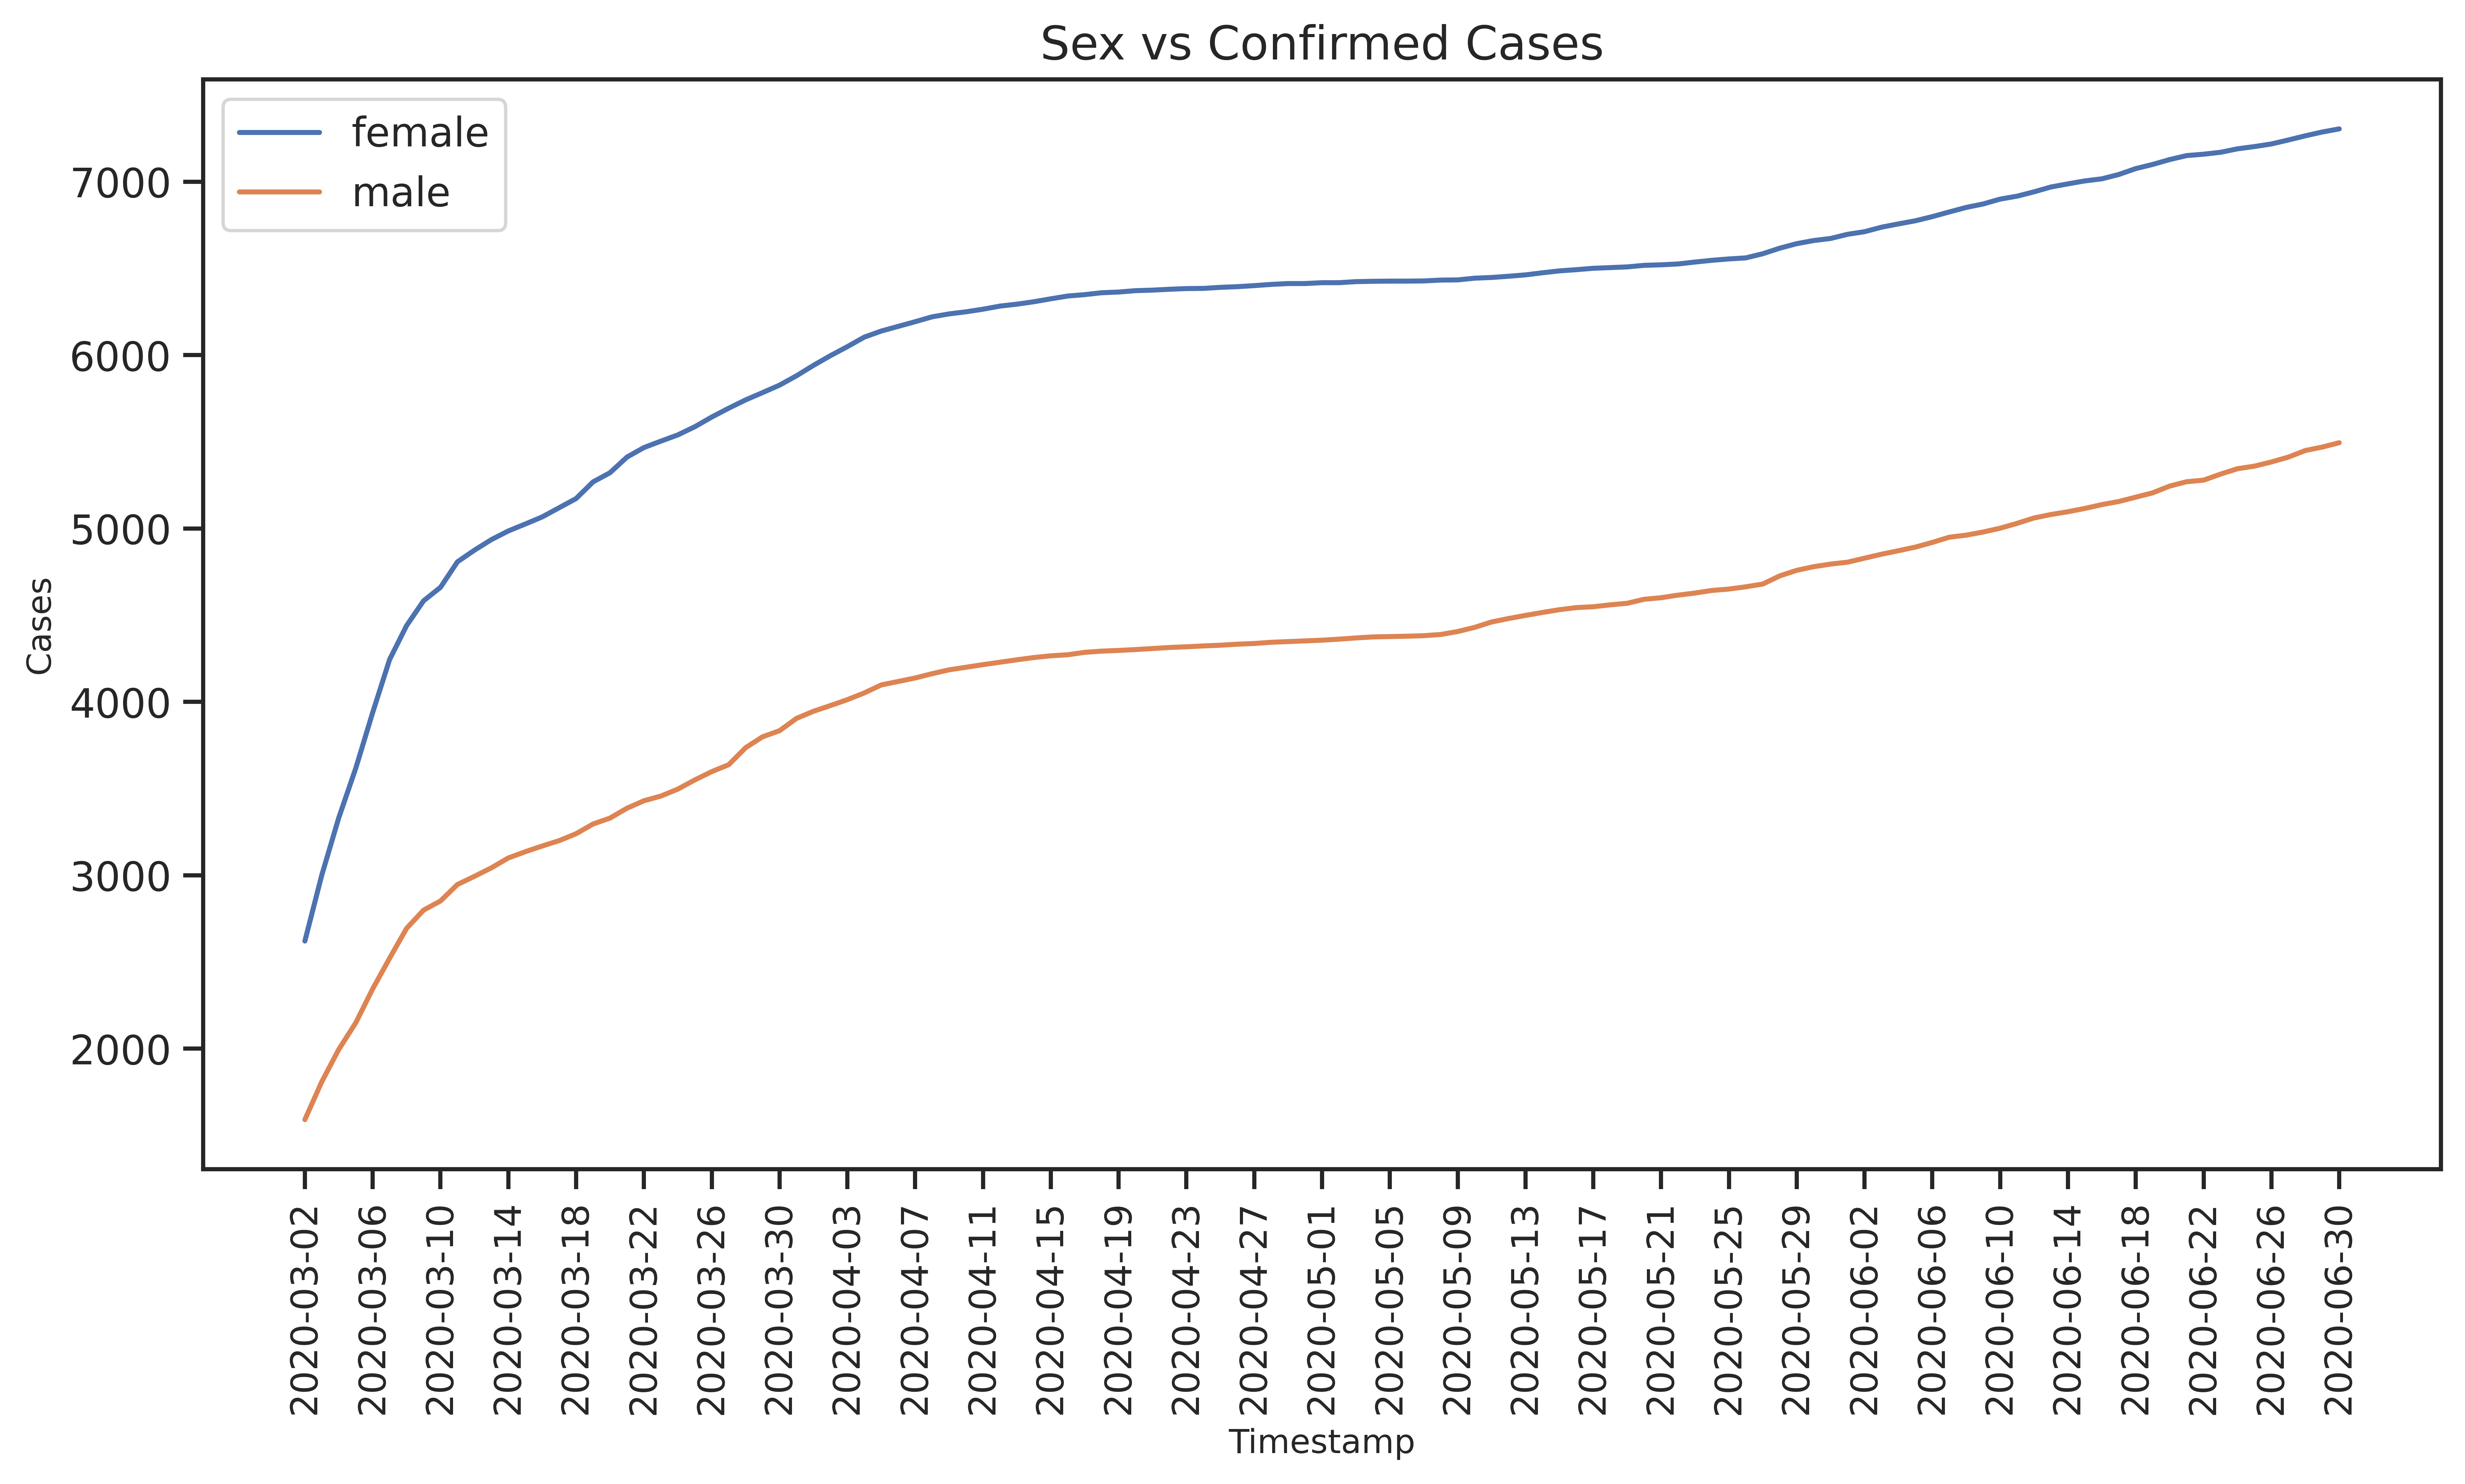

<Figure size 8400x4200 with 0 Axes>

In [ ]:
sns.set(rc={"figure.dpi":700, 'savefig.dpi':700})
sns.set_style('ticks')
fontsize = 12

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Sex vs Confirmed Cases", fontsize=14)
plt.ylabel("Cases", fontsize=10)
plt.xlabel("Timestamp", fontsize=10)

plt.xticks(list(range(len(dates))), dates[::4], rotation='vertical')
plt.locator_params(axis='x', nbins=len(dates)/4)
plt.yticks(fontsize= fontsize)

for i in range(len(sexes_confirmed)):
  sex = [list(x[1].items())[i][0] for x in TimeGender_dates_sexes_confirmed][0]
  sex_list = [list(x[1].items())[i][1] for x in TimeGender_dates_sexes_confirmed]
  plt.plot(sex_list, label = str(sex).split('_')[0], linestyle='-')


plt.legend(prop={'size': fontsize})
plt.show()
plt.clf()

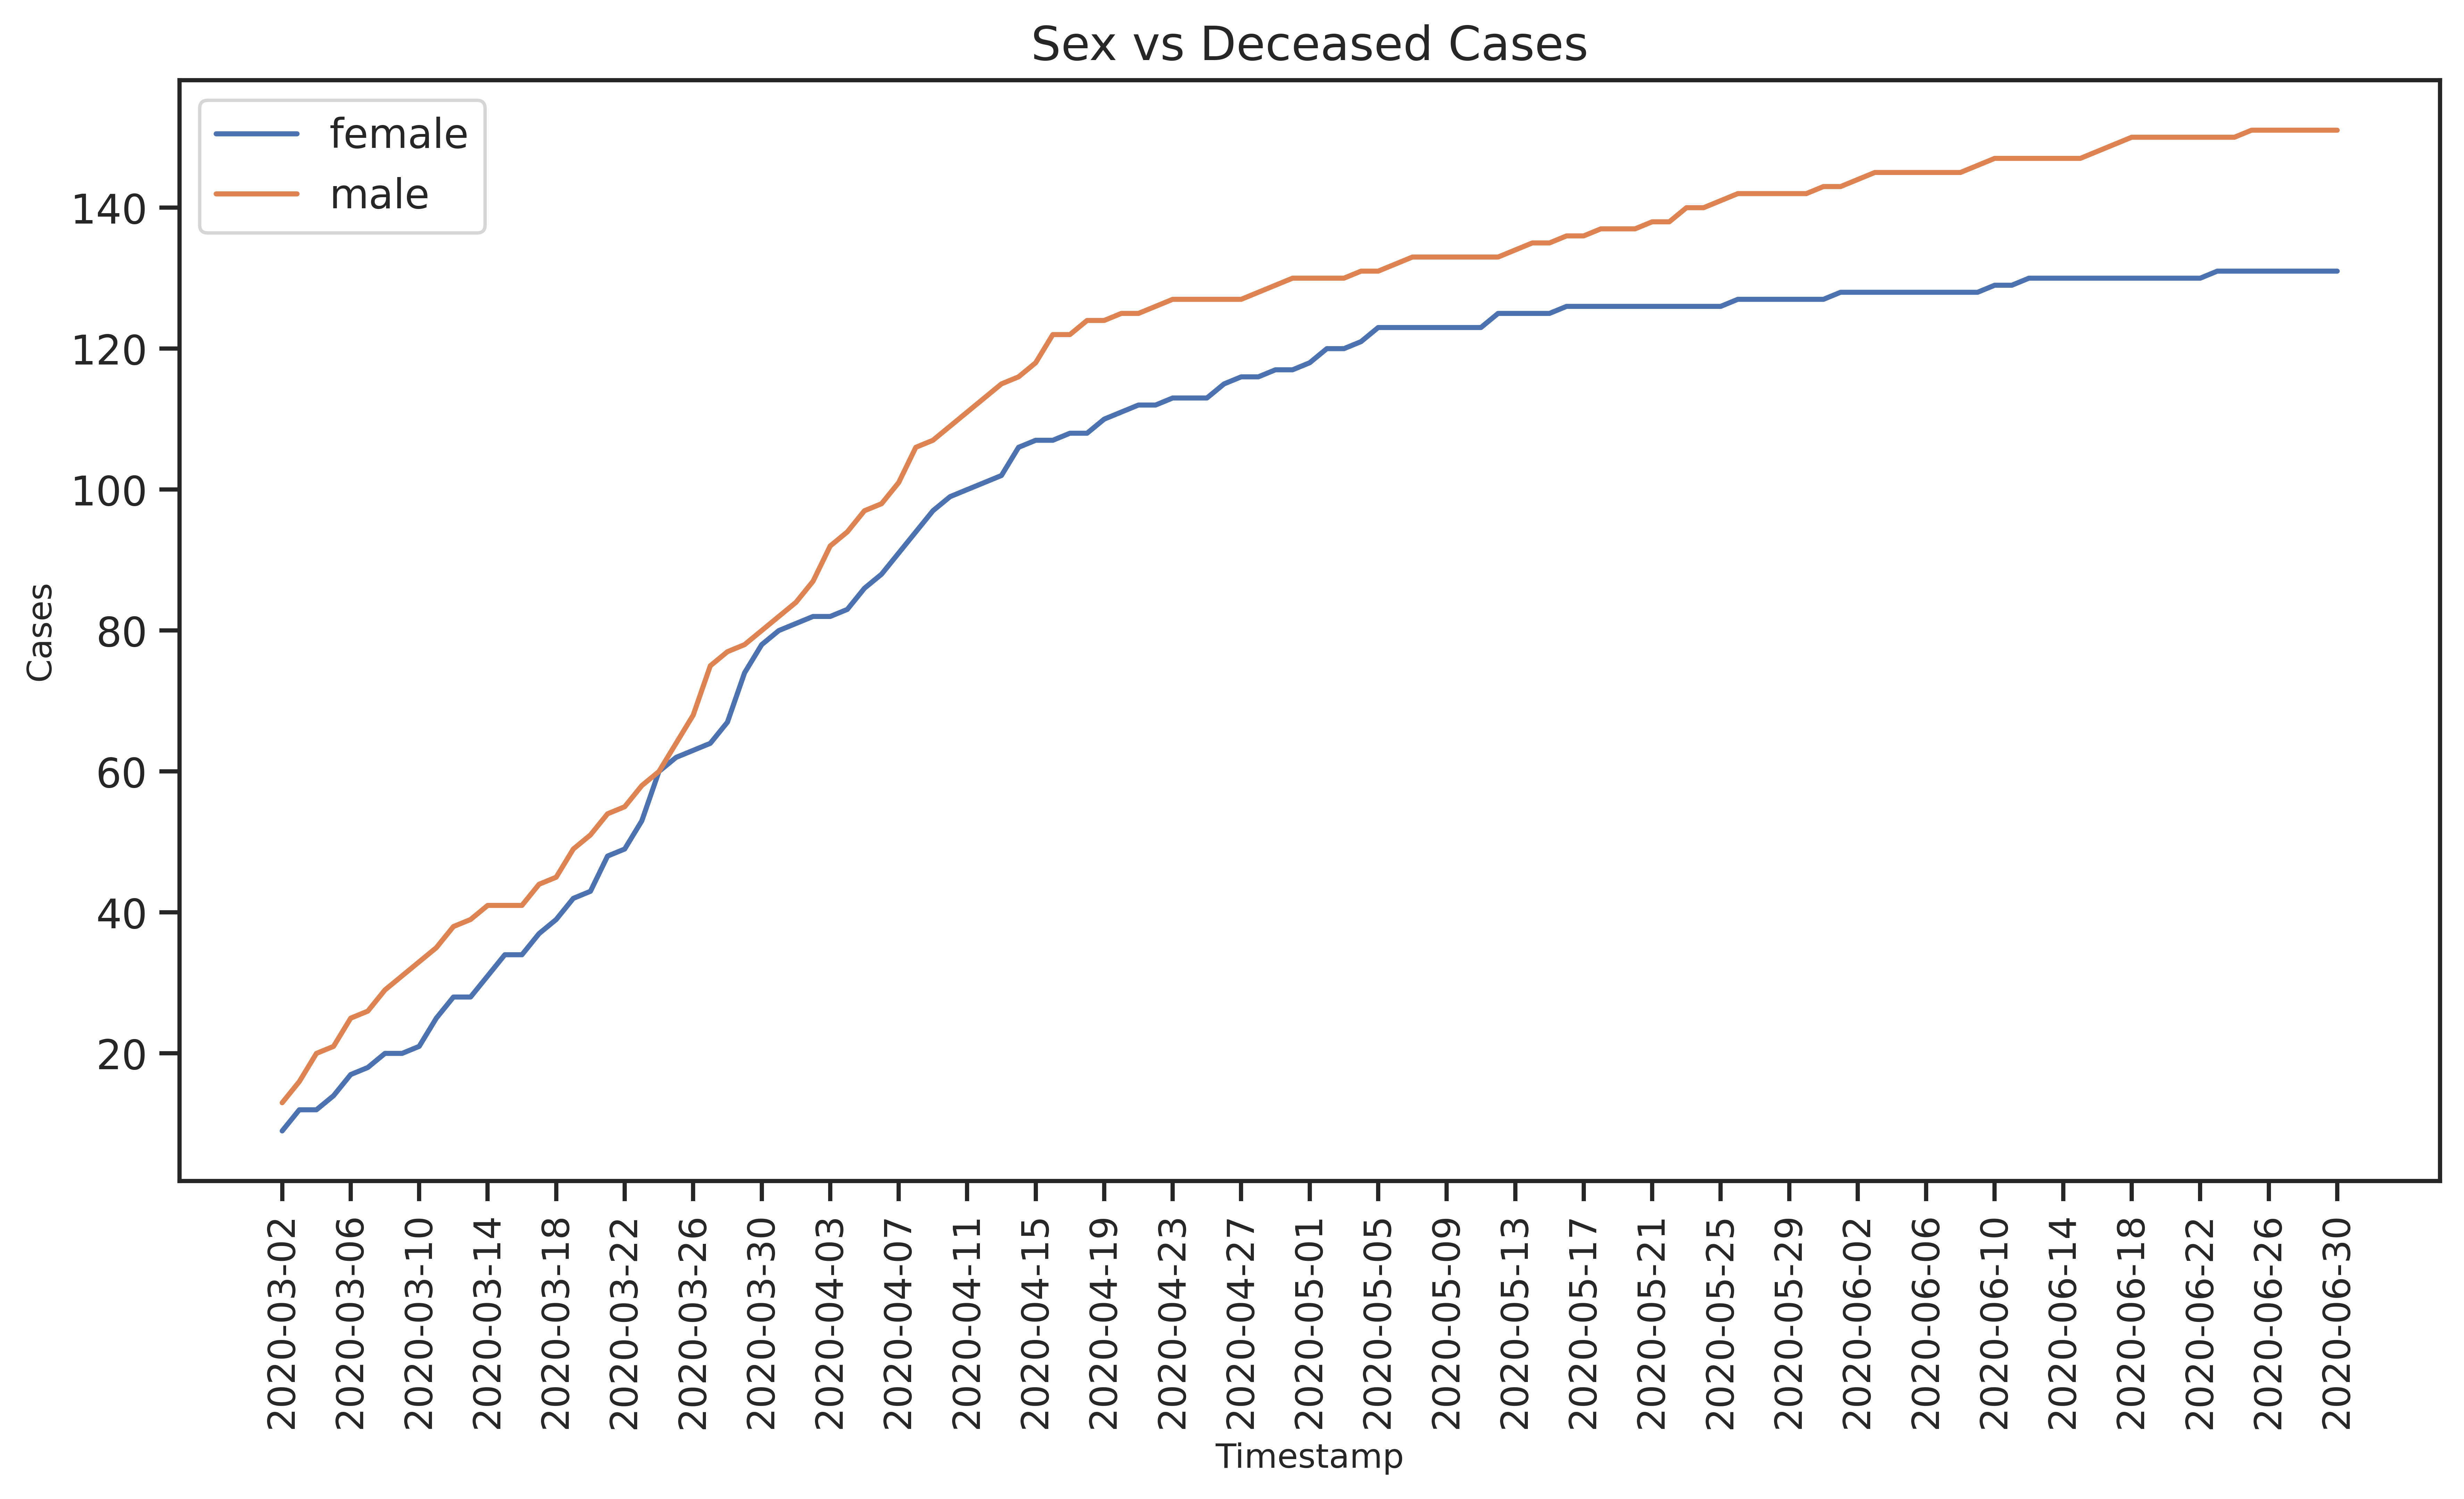

<Figure size 8400x4200 with 0 Axes>

In [ ]:
sns.set(rc={"figure.dpi":700, 'savefig.dpi':700})
sns.set_style('ticks')
fontsize = 12

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Sex vs Deceased Cases", fontsize=14)
plt.ylabel("Cases", fontsize=10)
plt.xlabel("Timestamp", fontsize=10)

plt.xticks(list(range(len(dates))), dates[::4], rotation='vertical')
plt.locator_params(axis='x', nbins=len(dates)/4)
plt.yticks(fontsize= fontsize)

for i in range(len(sexes_deceased)):
  sex = [list(x[1].items())[i][0] for x in TimeGender_dates_sexes_deceased][0]
  sex_list = [list(x[1].items())[i][1] for x in TimeGender_dates_sexes_deceased]
  plt.plot(sex_list, label = str(sex).split('_')[0], linestyle='-')


plt.legend(prop={'size': fontsize})
plt.show()
plt.clf()